Florida Panthers Hockey Club Historical Review (2017/18-2023/24)

YoY Metrics to Track:

~ Tickets
    ~ How have our biggest games improved? Smallest Games? Season Averages? Post-Season?
    ~ KPIs : Gross Revenue, Paid Tickets, ATP, Comp Ticket Conversion Rate
~ Attendance 
    ~ Once people buy do they show up? Single game show-rate? Plan show-rate? 
    ~ KPIs : Show Rate (by game/by tier/by ticket type)
~ Parking 
    ~ How do game factors influence parking numbers?
    ~ KPIs: Prepaid (difference with Seatgeek) v On-Site, People per Car, Per Cap, # of Cars
~ F&B 
    ~ How do game factors influence F&B numbers? Change by location? Parnerships?
    ~ KPIs: Gross Revenue, Per Cap, Avg Item Price
~ Merch
    ~ How do game factors influence merch numbers? Change by location?
    ~ KPIs: Gross Revenue, Per Cap, Avg Item Price
~ All-In Total
    ~ How much does it cost for someone to attend a Panthers game?

Other Factors to Consider:

~ COVID-19
~ On-ice performance
~ Growth of STM base

Data Sources Used:

~ cth_historical_all_1718_2223
~ cth_v_ticket_2324
~ cth_game_descriptions

Models Created: 

~ 

Future Considerations:

~ 

In [1]:
import pandas as pd
import numpy as np
from catnip.fla_redshift import FLA_Redshift
from sqlalchemy import null
from datetime import datetime

from prefect.blocks.system import Secret
from typing import Dict
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt

In [2]:
def get_redshift_credentials() -> Dict:

    cred_dict = {
        "dbname": Secret.load("stellar-redshift-db-name").get(),
        "host": Secret.load("stellar-redshift-host").get(),
        "port": 5439,
        "user": Secret.load("stellar-redshift-user-name").get(),
        "password": Secret.load("stellar-redshift-password").get(),

        "aws_access_key_id": Secret.load("fla-s3-aws-access-key-id-east-1").get(),
        "aws_secret_access_key": Secret.load("fla-s3-aws-secret-access-key-east-1").get(),
        "bucket": Secret.load("fla-s3-bucket-name-east-1").get(),
        "subdirectory": "us-east-1",

        "verbose": False,
    }

    return cred_dict

with ThreadPoolExecutor(1) as pool:
    rs_creds = pool.submit(lambda: get_redshift_credentials()).result()

Part I ~ Tickets

In [ ]:
# all regular season games since 2017-18 (excluding covid season) paid seats, comp seats, gross revenue, ATP
    # quick pivot by tier, opponent, ticket type, goal?
    # growth of STMs
    # bowl analysis
    # num of each tier of games by season, points % of team each season (first half? if they made the playoffs?)
    # YoY Growth by each metric - model for equation that shows growth to predict into future on current trajectory?       

In [3]:
# import data

q = """
WITH all_games AS
    (SELECT
        season, date(event_date) as event_date, ticket_type,
        CASE
            when pc_one in ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', '1', '2', '3', '4', '5', '6', '7', '8') then 'Lowers'
            when pc_one in ('K', 'L', 'M') then 'Clubs'
            when pc_one in ('N', 'O', 'P', 'Q', 'R', 'S', 'T', 'Y') then 'Uppers'
            when pc_one in ('U', 'V', 'W') then 'Suites'
            when pc_one in ('X', 'Z') then 'Premium'
        end as arena_level_internal,
        cast(sum(gross_revenue) as int) as gross_revenue,
        sum(paid_seats) as paid_seats, sum(gross_revenue)/nullif(sum(paid_seats),0) as gross_atp
    FROM
        custom.cth_historical_all_1718_2223
    WHERE
        season != '2020-21'
    GROUP BY
        season, event_date, ticket_type, arena_level_internal
    UNION ALL
    SELECT
        '2023-24' as season, date(event_datetime) as event_date, ticket_type, arena_level_internal,
        cast(sum(gross_revenue) as int) as gross_revenue, sum(paid_seats) as paid_seats,
        sum(gross_revenue)/nullif(sum(paid_seats),0) as gross_atp
    FROM
        custom.cth_v_ticket_2324
    GROUP BY
        season, event_date, ticket_type, arena_level_internal)
SELECT
    all_games.*, tier, abbreviation
FROM
    all_games
LEFT JOIN
    custom.cth_game_descriptions on all_games.event_date = cth_game_descriptions.event_date
WHERE
    tier in ('A','B','C','D','E')
ORDER BY
    season, event_date, ticket_type, arena_level_internal
"""

df = FLA_Redshift(**rs_creds).query_warehouse(sql_string = q)

In [4]:
df1 = df.copy()
df1["gross_revenue"] = df1["gross_revenue"].map("${:,.0f}".format)
# df.head(10).rename(columns=lambda name: name.replace('_', ' ')).style \
#   .set_caption("Total Table") \
#   .format(precision=0, thousands = ',') \
#   .format_index(str.title, axis=1)

In [5]:
# By Game
df_pivot = df.groupby(by = ['season', 'event_date', 'tier','abbreviation'], axis = 0).agg({'gross_revenue':'sum','paid_seats' : 'sum','gross_atp':'mean'})
df_pivot_final= pd.DataFrame(df_pivot).reset_index()
#df_pivot_final["gross_revenue"] = df_pivot_final["gross_revenue"].map("${:,.0f}".format)
# df_pivot_final[df_pivot_final['season'] == '2023-24'].rename(columns=lambda name: name.replace('_', ' ')).style \
#   .set_caption("Game Table") \
#   .format(precision=0, thousands = ',') \
#   .format_index(str.title, axis=1)

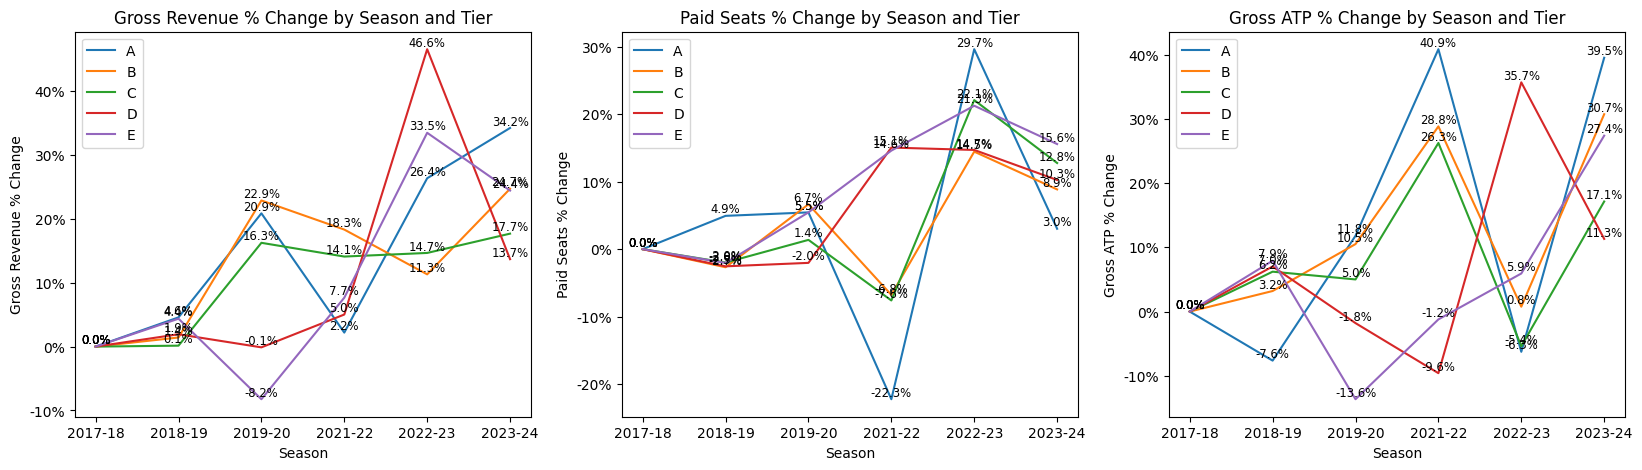

In [6]:
# By Tier
df_tier = df_pivot.groupby(by = ['tier', 'season'], axis = 0)[['gross_revenue','paid_seats','gross_atp']].mean()

df_tier_final = pd.DataFrame(df_tier).reset_index()
#df_tier_final["gross_revenue"] = df_tier_final["gross_revenue"].map("${:,.0f}".format)

pct_change = df_tier.pct_change()

pct_change = pd.DataFrame(pct_change).reset_index().rename(columns = {'gross_revenue' : 'gross_revenue_%_change', 'paid_seats' : 'paid_seats_%_change',
                                                                       'gross_atp' : 'gross_atp_%_change'})
pct_change[pct_change['season'] == '2017-18'] = 0
df_tier_final = df_tier_final.merge(right = pct_change, how = 'left', on = ['season','tier']).fillna(0)[['tier','season','gross_revenue','gross_revenue_%_change', 
                                                                                                         'paid_seats','paid_seats_%_change','gross_atp','gross_atp_%_change']]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

# Plot gross_revenue_%_change by season for each tier
for tier in df_tier_final['tier'].unique():
    tier_data = df_tier_final[df_tier_final['tier'] == tier]
    ax1.plot(tier_data['season'], tier_data['gross_revenue_%_change'], label=tier)

# Format y-axis as percentages
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: '{:.0%}'.format(x)))

# Add labels to each point
for i, row in df_tier_final.iterrows():
    ax1.text(row['season'], row['gross_revenue_%_change'], f"{row['gross_revenue_%_change']:.1%}", ha='center', va='bottom', size = 'small')

# Set labels and title for the first subplot
ax1.set_xlabel('Season')
ax1.set_ylabel('Gross Revenue % Change')
ax1.set_title('Gross Revenue % Change by Season and Tier')
ax1.legend()

# Plot paid_seats_%_change by season for each tier
for tier in df_tier_final['tier'].unique():
    tier_data = df_tier_final[df_tier_final['tier'] == tier]
    ax2.plot(tier_data['season'], tier_data['paid_seats_%_change'], label=tier)

# Format y-axis as percentages
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: '{:.0%}'.format(x)))

# Add labels to each point
for i, row in df_tier_final.iterrows():
    ax2.text(row['season'], row['paid_seats_%_change'], f"{row['paid_seats_%_change']:.1%}", ha='center', va='bottom', size = 'small')

# Set labels and title for the second subplot
ax2.set_xlabel('Season')
ax2.set_ylabel('Paid Seats % Change')
ax2.set_title('Paid Seats % Change by Season and Tier')
ax2.legend()

# Plot paid_seats_%_change by season for each tier
for tier in df_tier_final['tier'].unique():
    tier_data = df_tier_final[df_tier_final['tier'] == tier]
    ax3.plot(tier_data['season'], tier_data['gross_atp_%_change'], label=tier)

# Format y-axis as percentages
ax3.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: '{:.0%}'.format(x)))

# Add labels to each point
for i, row in df_tier_final.iterrows():
    ax3.text(row['season'], row['gross_atp_%_change'], f"{row['gross_atp_%_change']:.1%}", ha='center', va='bottom', size = 'small')

# Set labels and title for the second subplot
ax3.set_xlabel('Season')
ax3.set_ylabel('Gross ATP % Change')
ax3.set_title('Gross ATP % Change by Season and Tier')
ax3.legend()

# Show the plot
plt.show()

What does the above show?

Gross Revenue, Paid Seats, and Gross ATP are all trending upwards over the last 6 seasons. Some seasons (specifically 2021-22) have seen dips possibly due to people more hesitant to return because of remnants of COVID. This past season 2023-24 have seen an increase in every tier for every KPI. We are selling more tickets at a higher price for a larger total gross revenue.

Specifically, the ATP for the A-tier games has seen the largest jump, and we have seen that reflected as the A-tier has also seen the highest Gross Revenue increase. This means our biggest games of the year are bigger draws for local fans.

Our lower tier games (C,D and E) have all seen the largest jumps in paid seats (12.8%, 10.3%, and 15.6%) respectively which means that even the non-marquee matchups against less desirable opponents, days of the week, or start times are drawing more and more fans. This means that our fanbase is growing, and we have a larger number of people who want to come to see the Panthers no matter the opponent or day of week. 

From this we can gather that our base is becoming more elastic with what they are willing to pay to see the Panthers. No matter who they are playing or when fans want to come to games. 


How can we use this for next season?

As we know our fanbase is growing stronger we can increase our goals for lower tiered games, as we have consistently outperformed our goals this past season.

In [9]:
# def format_percentage(val):
#     return f"{val:.1%}"

# # Define a function to format numbers with commas
# def format_number(val):
#     return f"{val:,.0f}"

# # Define a function to format currency
# def format_currency(val):
#     return f"${val:,.0f}"

# # Apply formatting to the DataFrame
# styled_df = df_tier_final.style.format({
#     'gross_revenue_%_change': format_percentage,
#     'paid_seats_%_change': format_percentage,
#     'comp_seats_%_change': format_percentage,
#     'paid_seats': format_number,
#     'comp_seats': format_number,
#     'gross_revenue': format_currency
# })
# #.background_gradient(subset=['gross_revenue_%_change', 'paid_seats_%_change', 'comp_seats_%_change'], cmap='RdYlGn')
# styled_df

In [10]:
# # By Game
# df_abbr = df_pivot.groupby(by = ['abbreviation', 'season'], axis = 0)[['gross_revenue','paid_seats','comp_seats']].mean()

# df_abbr_final= pd.DataFrame(df_abbr).reset_index()
# df_abbr_final["gross_revenue"] = df_abbr_final["gross_revenue"].map("${:,.0f}".format)

# pct_change = df_abbr.pct_change()
# pct_change = pd.DataFrame(pct_change).reset_index().rename(columns = {'gross_revenue' : 'gross_revenue_%_change', 'paid_seats' : 'paid_seats_%_change',
#                                                                         'comp_seats' : 'comp_seats_%_change'})
# pct_change[pct_change['season'] == '2017-18'] = 0
# df_abbr_final = df_abbr_final.merge(right = pct_change, how = 'left', on = ['season','abbreviation']).fillna(0)[['abbreviation','season','gross_revenue','gross_revenue_%_change', 
#                                                                                                           'paid_seats','paid_seats_%_change','comp_seats','comp_seats_%_change']]

# # mapper =  {'paid_seats': '{0:,.0f}',
# #            'comp_seats': '{0:,.0f}',
# #            'gross_revenue_%_change': '{0:.1f}%',
# #            'paid_seats_%_change': '{0:.1f}%',
# #            'comp_seats_%_change': '{0:.1f}%'}

# # for key, value in mapper.items():
# #    df_abbr_final[key] = df_abbr_final[key].apply(value.format)

# # df_abbr_final[df_abbr_final['season'] == '2023-24'].rename(columns=lambda name: name.replace('_', ' ')).style \
# #   .set_caption("Tier Comparison Table") \
# #   .format_index(str.title, axis=1) \
# #   .background_gradient(cmap = 'RdYlGn') \
# #   .format(mapper)

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# # Plot gross_revenue_%_change by season for each tier
# df_temp = df_abbr_final[df_abbr_final['abbreviation'].isin(['VGK','WSH','TOR','BOS','TBL','CAR'])]
# for tier in df_temp['abbreviation'].unique():
#     tier_data = df_temp[df_temp['abbreviation'] == tier]
#     ax1.plot(tier_data['season'], tier_data['gross_revenue_%_change'], label=tier)

# # Format y-axis as percentages
# ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: '{:.0%}'.format(x)))

# # Add labels to each point
# for i, row in df_temp.iterrows():
#     ax1.text(row['season'], row['gross_revenue_%_change'], f"{row['gross_revenue_%_change']:.1%}", ha='center', va='bottom', size = 'small')

# # Set labels and title for the first subplot
# ax1.set_xlabel('Season')
# ax1.set_ylabel('Gross Revenue % Change')
# ax1.set_title('Gross Revenue % Change by Season and Tier')
# ax1.legend()

# # Plot paid_seats_%_change by season for each tier
# for tier in df_temp['abbreviation'].unique():
#     tier_data = df_temp[df_temp['abbreviation'] == tier]
#     ax2.plot(tier_data['season'], tier_data['paid_seats_%_change'], label=tier)

# # Format y-axis as percentages
# ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: '{:.0%}'.format(x)))

# # Add labels to each point
# for i, row in df_temp.iterrows():
#     ax2.text(row['season'], row['paid_seats_%_change'], f"{row['paid_seats_%_change']:.1%}", ha='center', va='bottom', size = 'small')

# # Set labels and title for the second subplot
# ax2.set_xlabel('Season')
# ax2.set_ylabel('Paid Seats % Change')
# ax2.set_title('Paid Seats % Change by Season and Tier')
# ax2.legend()

# # Show the plot
# plt.show()

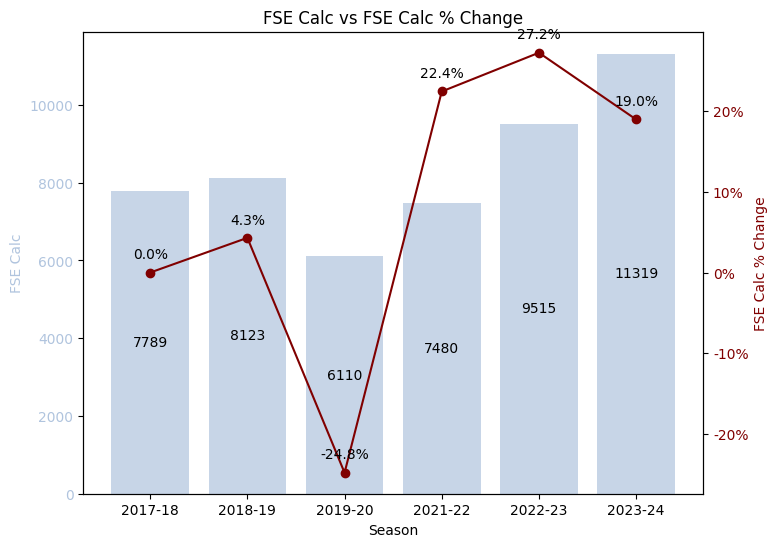

In [23]:
# STM comparison
df_stms = df[df['ticket_type'].isin(['Full','Annual Suites','Premier','Half'])]
df_stms = df_stms.groupby(by = ['season', 'ticket_type'], axis = 0)[['gross_revenue','paid_seats','gross_atp']].sum()
df_stms= pd.DataFrame(df_stms).reset_index()

df_stms['fse_calc'] = df_stms.apply(lambda row: round(row['paid_seats']/42,2) if row['ticket_type'] == 'Annual Suites' or row['ticket_type'] == 'Full' else 
                                    (row['paid_seats']/20 if row['ticket_type'] == 'Half' else row['paid_seats']/25), axis = 1)
df_stms = df_stms.groupby(by = 'season', axis = 0)[['fse_calc']].sum()
df_stms_final= pd.DataFrame(df_stms).reset_index()

pct_change = df_stms[['fse_calc']].pct_change()

pct_change = pd.DataFrame(pct_change).reset_index().rename(columns = {'fse_calc' : 'fse_calc_%_change'})
pct_change[pct_change['season'] == '2017-18'] = 0
df_stms_final = df_stms_final.merge(right = pct_change, how = 'left', on = ['season']).fillna(0)

# df_stms_final.rename(columns=lambda name: name.replace('_', ' ')).style \
#   .set_caption("Tier Comparison Table") \
#   .format_index(str.title, axis=1) \
#   .background_gradient(axis = 1, cmap = 'RdYlGn', vmin = 0, vmax = 100)

# Create a figure and a primary axes for the bar graph
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot the bar graph on the primary axes
bars = ax1.bar(df_stms_final['season'], df_stms_final['fse_calc'], color='lightsteelblue', alpha=0.7)
ax1.set_ylabel('FSE Calc', color='lightsteelblue')
ax1.tick_params(axis='y', labelcolor='lightsteelblue')

# Add labels to the bars
ax1.bar_label(bars, label_type='center', fmt='%d')

# Create a twin axes for the line graph
ax2 = ax1.twinx()

# Format y-axis as percentages
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: '{:.0%}'.format(x)))

# Plot the line graph on the twin axes
ax2.plot(df_stms_final['season'], df_stms_final['fse_calc_%_change'], color='maroon', marker='o')
ax2.set_ylabel('FSE Calc % Change', color='maroon')
ax2.tick_params(axis='y', labelcolor='maroon')

# Add labels to the points on the line
for i, (x, y) in enumerate(zip(df_stms_final['season'], df_stms_final['fse_calc_%_change'])):
    label = f'{y*100:.1f}%'
    ax2.annotate(label, (x, y), textcoords="offset points", xytext=(0,10), ha='center')

# Set the title and labels for the X-axis
ax1.set_title('FSE Calc vs FSE Calc % Change')
ax1.set_xlabel('Season')

# Display the plot
plt.show()

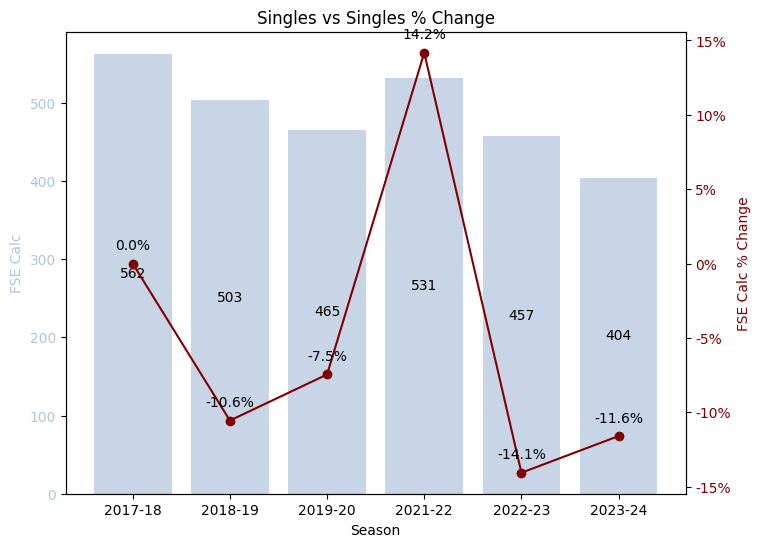

In [31]:
# STM comparison
df_singles = df[df['ticket_type'].isin(['Singles'])]
df_singles = df_singles.groupby(by = ['season'], axis = 0).agg({'gross_revenue':'mean','paid_seats' : 'mean','gross_atp':'mean'})

# df_singles = df_singles.groupby(by = ['season', 'ticket_type'], axis = 0)[['gross_revenue','paid_seats','gross_atp']].mean()

pct_change = df_singles.pct_change()

pct_change = pd.DataFrame(pct_change).reset_index().rename(columns = {'gross_revenue' : 'gross_revenue_%_change', 'paid_seats' : 'paid_seats_%_change',
                                                                        'gross_atp' : 'gross_atp_%_change'})
# pct_change[pct_change['season'] == '2017-18'] = 0
df_singles = df_singles.merge(right = pct_change, how = 'left', on = ['season']).fillna(0)

# df_stms_final.rename(columns=lambda name: name.replace('_', ' ')).style \
#   .set_caption("Tier Comparison Table") \
#   .format_index(str.title, axis=1) \
#   .background_gradient(axis = 1, cmap = 'RdYlGn', vmin = 0, vmax = 100)

# Create a figure and a primary axes for the bar graph
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot the bar graph on the primary axes
bars = ax1.bar(df_singles['season'], df_singles['paid_seats'], color='lightsteelblue', alpha=0.7)
ax1.set_ylabel('FSE Calc', color='lightsteelblue')
ax1.tick_params(axis='y', labelcolor='lightsteelblue')

# Add labels to the bars
ax1.bar_label(bars, label_type='center', fmt='%d')

# Create a twin axes for the line graph
ax2 = ax1.twinx()

# Format y-axis as percentages
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: '{:.0%}'.format(x)))

# Plot the line graph on the twin axes
ax2.plot(df_singles['season'], df_singles['paid_seats_%_change'], color='maroon', marker='o')
ax2.set_ylabel('FSE Calc % Change', color='maroon')
ax2.tick_params(axis='y', labelcolor='maroon')

# Add labels to the points on the line
for i, (x, y) in enumerate(zip(df_singles['season'], df_singles['paid_seats_%_change'])):
    label = f'{y*100:.1f}%'
    ax2.annotate(label, (x, y), textcoords="offset points", xytext=(0,10), ha='center')

# Set the title and labels for the X-axis
ax1.set_title('Singles vs Singles % Change')
ax1.set_xlabel('Season')

# Display the plot
plt.show()

In [32]:
# capacity for singles has dipped YoY
df_singles = df_singles.merge(df_stms_final, how = 'left', on = 'season')
df_singles['capacity'] = (19500-df_singles['fse_calc'])
df_singles['per_sold'] = df_singles['paid_seats']/df_singles['capacity']
df_singles

,season,gross_revenue,paid_seats,gross_atp,gross_revenue_%_change,paid_seats_%_change,gross_atp_%_change,fse_calc,fse_calc_%_change,capacity,per_sold
0,2017-18,34437.237805,562.884146,79.185641,0.000000,0.000000,0.000000,7789.12,0.000000,11710.88,0.048065
1,2018-19,31484.668750,503.487500,82.292559,-0.085738,-0.105522,0.039236,8123.85,0.042974,11376.15,0.044258
2,2019-20,32914.085714,465.942857,83.707322,0.045400,-0.074569,0.017192,6110.97,-0.247774,13389.03,0.034800
3,2021-22,43003.475610,531.975610,93.145569,0.306537,0.141719,0.112753,7480.53,0.224115,12019.47,0.044259
4,2022-23,32898.890244,457.182927,106.594541,-0.234971,-0.140594,0.144387,9515.92,0.272092,9984.08,0.045791
5,2023-24,22924.304878,404.176829,129.991459,-0.303189,-0.115941,0.219495,11319.27,0.189509,8180.73,0.049406


What does the above show?

We have steadily increased our STM base over the last 4 seasons, as we recovered from the COVID dip in 2019-20. This means our base revenue is much higher for every game. Conversely, we have less and less avaliability for nightly tickets and so the number of paid seats in these buckets will most likely decrease. A smaller supply means as our fanbase increases and the number of nightly tickets gets smaller we will be able to slowly increase the ATP of these tickets, so even though paid seats will be down our gross revenue can remain the same, or only dip a small amount. 

How can we use this in the future?

If we know our goals for each ticket type for the 2024-25 season, and the amount of inventory we will have we will be able to price nightly tickets appropriately in order to meet out budget goals. As we increase demand we will also be able to cap our season tickets by creating a maximizing function on gross revenue to make sure we are not leaving revenue on the table. 

Ideal supply per price code 7 days out to increase prices at a linear rate until game day and still sell through - lowest ATP 1-2 months out

Map sales by buckets to see demand and price accordingly to maximize revenue for ALL games.

In [21]:
df_singles = df[df['ticket_type'].isin(['Singles'])]
df_singles = df_singles.groupby(by = ['season', 'tier'], axis = 0)[['gross_revenue','paid_seats','gross_atp']].mean()
df_singles = pd.DataFrame(df_singles).reset_index()
df_singles['atp'] = df_singles['gross_revenue']/df_singles['paid_seats']
df_singles
# get singles goal, project tickets out and make ATP accordingly 

,season,tier,gross_revenue,paid_seats,gross_atp,atp
0,2017-18,A,103946.250000,1207.500000,124.412646,86.083851
1,2017-18,B,65754.458333,961.416667,92.260729,68.393300
2,2017-18,C,44885.812500,768.625000,79.114662,58.397544
3,2017-18,D,21113.615385,389.480769,73.198864,54.209648
4,2017-18,E,11149.666667,201.722222,74.185898,55.272377
5,2018-19,A,106552.250000,1237.000000,126.173945,86.137631
6,2018-19,B,62958.500000,864.000000,100.748096,72.868634
7,2018-19,C,40977.416667,733.333333,78.304556,55.878295
8,2018-19,D,20886.644737,383.894737,75.409191,54.407218
9,2018-19,E,9916.321429,165.785714,79.669969,59.814089


In [42]:
df_singles = df[df['ticket_type'].isin(['Secondary'])]
df_singles = df_singles.groupby(by = ['season', 'tier'], axis = 0)[['gross_revenue','paid_seats']].mean()
df_singles = pd.DataFrame(df_singles).reset_index()
df_singles['atp'] = df_singles['gross_revenue']/df_singles['paid_seats']
df_singles

,season,tier,gross_revenue,paid_seats,atp
0,2017-18,A,25941.000000,238.750000,108.653403
1,2017-18,B,20634.166667,271.166667,76.094038
2,2017-18,C,14686.395833,245.041667,59.934280
3,2017-18,D,8890.096154,190.653846,46.629514
4,2017-18,E,5076.305556,108.527778,46.774251
5,2018-19,A,39764.750000,412.500000,96.399394
6,2018-19,B,20694.214286,290.000000,71.359360
7,2018-19,C,13424.583333,241.541667,55.578748
8,2018-19,D,8401.920000,174.013333,48.283197
9,2018-19,E,3500.357143,64.964286,53.881253


In [ ]:
# bowl analysis

# breakdown of bowl by season by ticket_type % (ticket_type groups?), maximizing function for gross (A&B) paid seats (C&D&E)
# what % bowl STM

Part II ~ Attendance

In [ ]:
# all regular season games since 2017-18 (excluding covid season?) paid attendance, comp attendance, paid show rate, comp show rate
    # quick pivot by tier, ticket type
    # num of plan tickets sold/scanned by another account
    # bowl analysis
    # num of each tier of games by season, points % of team each season (first half? if they made the playoffs?)
    # YoY Growth by each metric - model for equation that shows growth to predict into future on current trajectory?

In [9]:
# import data

q = """
WITH all_games AS
    (SELECT
        season, date(event_date) as event_date, ticket_type,
        CASE
            when pc_one in ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', '1', '2', '3', '4', '5', '6', '7', '8') then 'Lowers'
            when pc_one in ('K', 'L', 'M') then 'Clubs'
            when pc_one in ('N', 'O', 'P', 'Q', 'R', 'S', 'T', 'Y') then 'Uppers'
            when pc_one in ('U', 'V', 'W') then 'Suites'
            when pc_one in ('X', 'Z') then 'Premium'
        end as arena_level_internal, sum(paid_seats) as paid_seats, sum(comp_seats) as comp_seats,
        sum(paid_attended) as paid_attended, sum(comp_attended) as comp_attended
    FROM
        custom.cth_historical_all_1718_2223
    WHERE
        season != '2020-21'
    GROUP BY
        season, event_date, ticket_type, arena_level_internal
    UNION ALL
    SELECT
        '2023-24' as season, date(event_datetime) as event_date, ticket_type,
        CASE
            when left(price_code,1) in ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', '1', '2', '3', '4', '5', '6', '7', '8') then 'Lowers'
            when left(price_code,1) in ('K', 'L', 'M') then 'Clubs'
            when left(price_code,1) in ('N', 'O', 'P', 'Q', 'R', 'S', 'T', 'Y') then 'Uppers'
            when left(price_code,1) in ('U', 'V', 'W') then 'Suites'
            when left(price_code,1) in ('X', 'Z') then 'Premium'
        end as arena_level_internal,
        sum(paid_seats) as paid_seats, sum(comp_seats) as comp_seats,
        CASE
            when cth_v_attendance_2324.is_comp = False then 1
            else 0
        end as paid_attended,
        CASE
            when cth_v_attendance_2324.is_comp = True then 1
            else 0
        end as comp_attended
    FROM
        custom.cth_v_attendance_2324
    GROUP BY
        season, event_date, ticket_type, price_code, cth_v_attendance_2324.is_comp)
SELECT
    all_games.*, tier, abbreviation
FROM
    all_games
LEFT JOIN
    custom.cth_game_descriptions on all_games.event_date = cth_game_descriptions.event_date
WHERE
    tier in ('A','B','C','D','E')
ORDER BY
    season, event_date, ticket_type, arena_level_internal
"""

df = FLA_Redshift(**rs_creds).query_warehouse(sql_string = q)

In [10]:
df

,season,event_date,ticket_type,arena_level_internal,paid_seats,comp_seats,paid_attended,comp_attended,tier,abbreviation
0,2017-18,2017-10-07,Annual Suites,Suites,917.0,116.0,440,77,C,TBL
1,2017-18,2017-10-07,Full,Clubs,740.0,8.0,657,4,C,TBL
2,2017-18,2017-10-07,Full,Lowers,2622.0,191.0,2368,122,C,TBL
3,2017-18,2017-10-07,Full,Premium,458.0,8.0,373,4,C,TBL
4,2017-18,2017-10-07,Full,Uppers,1137.0,12.0,1039,7,C,TBL
...,...,...,...,...,...,...,...,...,...,...
23111,2023-24,2024-04-16,Trade,Lowers,2.0,0.0,1,0,B,TOR
23112,2023-24,2024-04-16,Trade,Premium,2.0,0.0,1,0,B,TOR
23113,2023-24,2024-04-16,Trade,Premium,4.0,0.0,1,0,B,TOR
23114,2023-24,2024-04-16,Trade,Uppers,4.0,0.0,1,0,B,TOR


In [15]:
# By Game
df_pivot = df.groupby(by = ['season', 'event_date', 'tier','abbreviation'], axis = 0).agg({'paid_seats':'sum','comp_seats' : 'sum','paid_attended':'sum','comp_attended':'sum'})
df_pivot_final= pd.DataFrame(df_pivot).reset_index()
df_pivot_final[df_pivot_final['season'] == '2023-24'].rename(columns=lambda name: name.replace('_', ' ')).style \
  .set_caption("Game Table") \
  .format(precision=0, thousands = ',') \
  .format_index(str.title, axis=1)

,Season,Event Date,Tier,Abbreviation,Paid Seats,Comp Seats,Paid Attended,Comp Attended
198,2023-24,2023-10-19,B,TOR,"14,015","1,378",361,38
199,2023-24,2023-10-21,D,VAN,"11,535",672,353,36
200,2023-24,2023-10-24,E,SJS,"10,261","1,667",303,39
201,2023-24,2023-10-28,C,SEA,"12,914",578,362,34
202,2023-24,2023-11-06,E,CBJ,"11,224","2,179",335,41
203,2023-24,2023-11-10,D,CAR,"14,945",500,383,34
204,2023-24,2023-11-12,D,CHI,"15,674",542,374,33
205,2023-24,2023-11-20,D,EDM,"14,880","1,880",364,43
206,2023-24,2023-11-22,B,BOS,"16,535",752,365,39
207,2023-24,2023-11-24,C,WPG,"15,029","1,171",371,38


Part III ~ Parking

In [ ]:
# all regular season games since 2017-18 (excluding covid season?) # cars, prepaid v onsite breakdown, gross revenue
    # quick pivot by tier, day of week/start time
    # prepaid v onsite analysis/growth by season
    # num of each tier of games by season, points % of team each season (first half? if they made the playoffs?)
    # YoY Growth by each metric - model for equation that shows growth to predict into future on current trajectory?

Part IV ~ F&B 

In [ ]:
# all regular season games since 2017-18 (excluding covid season?) gross revenue, # items, location in arena
    # quick pivot by tier, day of week/start time
    # by location/bowl level growth
    # parnership growth
    # num of each tier of games by season, points % of team each season (first half? if they made the playoffs?)
    # YoY Growth by each metric - model for equation that shows growth to predict into future on current trajectory?

Part V ~ Merch

In [ ]:
# all regular season games since 2017-18 (excluding covid season?) gross revenue, # items, location in arena
    # quick pivot by tier, trimester?
    # num of each tier of games by season, points % of team each season (first half? if they made the playoffs?)
    # YoY Growth by each metric - model for equation that shows growth to predict into future on current trajectory?

Part VI ~ All-In Total

In [ ]:
# aggregate all previous sections
    # how much additional revenue have we generated in total?
    # correlation: type of game and ancillary, influincing factors on per caps, correlation between different ancillary buckets,
    # more expensive ticket = more expensive ancillary or opposite? 